In [3]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import keras
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.utils import shuffle

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# 把所有年份的資料merge在一起,並存在data.csv裡
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [5]:
# 讀取data.csv
def readData():
    train = pd.read_csv("data.csv")
    return train

In [6]:
# 把年份換成西元年
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [7]:
# 增加features("年","月","日","第幾日")
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [8]:
# 把非數字的資料換成正確資料,並減少features("日期","成交股數","成交金額",等等...)
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [9]:
# 把資料normalize
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [10]:
# 創造出train的資料,train_x為輸入資料(所有features),train_y為輸出資料(開盤價的成長率,分為9個區段)
def buildTrain(train, pastDay=10, futureDay=1):
    X_train, Y_train, Z_train, W_train= [], [], [], []
    X,Y,Z,W=[],[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
        W_train.append(np.array(train.iloc[i:i+1]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    W=np.array(W_train)
    Z=(Z+W)/2
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        else:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y
'''
def buildTrain(train, pastDay=5, futureDay=1):
    X_train, Y_train, Z_train, a_train, b_train, c_train, d_train= [], [], [], [], [], [], []
    X,Y,Z,a,b,c,d=[],[],[],[],[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
        a_train.append(np.array(train.iloc[i:i+1]["開盤價"]))
        b_train.append(np.array(train.iloc[i+1:i+2]["開盤價"]))
        c_train.append(np.array(train.iloc[i+2:i+3]["開盤價"]))
        d_train.append(np.array(train.iloc[i+3:i+4]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    a=np.array(a_train)
    b=np.array(b_train)
    c=np.array(c_train)
    d=np.array(d_train)
    Z=(Z+a+b+c+d)/5
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        else:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y
'''

'\ndef buildTrain(train, pastDay=5, futureDay=1):\n    X_train, Y_train, Z_train, a_train, b_train, c_train, d_train= [], [], [], [], [], [], []\n    X,Y,Z,a,b,c,d=[],[],[],[],[],[],[]\n    for i in range(train.shape[0]-futureDay-pastDay):\n        X_train.append(np.array(train.iloc[i:i+pastDay]))\n        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))\n        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))\n        a_train.append(np.array(train.iloc[i:i+1]["開盤價"]))\n        b_train.append(np.array(train.iloc[i+1:i+2]["開盤價"]))\n        c_train.append(np.array(train.iloc[i+2:i+3]["開盤價"]))\n        d_train.append(np.array(train.iloc[i+3:i+4]["開盤價"]))\n    X=np.array(X_train)\n    Y=np.array(Y_train)\n    Z=np.array(Z_train)\n    a=np.array(a_train)\n    b=np.array(b_train)\n    c=np.array(c_train)\n    d=np.array(d_train)\n    Z=(Z+a+b+c+d)/5\n    Y=100*((Y-Z)/Z)\n    Y_train=[]\n    \n    for i in range(len(Y)):\n        if Y[i]<-3.5:\n   

In [11]:
# 把資料打亂
def shuffle(X,Y):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [12]:
# 將資料分成訓練資料和測試資料
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [13]:
# 建立模型
def buildModel(shape):
    model = Sequential()
    model.add(LSTM(150,input_shape=(shape[1],shape[2]),return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(150))
    model.add(Dropout(0.4))
    model.add(Dense(9))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [14]:
# 印出loss, accuracy,val_loss, val_accuracy
class History(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [15]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,5,1)
train_x2, train_y2 = buildTrain(temp,5,1)
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = History()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=150, batch_size=360, verbose=2,validation_split=0.1, callbacks=[callback,history])



C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 150)            94200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 150)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1359      
_________________________________________________________________
activation_1 (Activation)    (None, 9)                 0         
Total params: 276,159
Trainable params: 276,159
Non-trainable params: 0
_________________________________________________________________
Trai

Epoch 84/150
 - 1s - loss: 1.9893 - acc: 0.2485 - val_loss: 2.0331 - val_acc: 0.2280
Epoch 85/150
 - 1s - loss: 1.9896 - acc: 0.2461 - val_loss: 2.0216 - val_acc: 0.2136
Epoch 86/150
 - 1s - loss: 1.9832 - acc: 0.2441 - val_loss: 2.0351 - val_acc: 0.2298
Epoch 87/150
 - 1s - loss: 1.9879 - acc: 0.2497 - val_loss: 2.0246 - val_acc: 0.2262
Epoch 88/150
 - 1s - loss: 1.9814 - acc: 0.2513 - val_loss: 2.0203 - val_acc: 0.2334
Epoch 89/150
 - 1s - loss: 1.9765 - acc: 0.2543 - val_loss: 2.0296 - val_acc: 0.2316
Epoch 90/150
 - 1s - loss: 1.9754 - acc: 0.2521 - val_loss: 2.0233 - val_acc: 0.2334
Epoch 91/150
 - 1s - loss: 1.9742 - acc: 0.2581 - val_loss: 2.0252 - val_acc: 0.2226
Epoch 92/150
 - 1s - loss: 1.9755 - acc: 0.2491 - val_loss: 2.0217 - val_acc: 0.2262
Epoch 93/150
 - 1s - loss: 1.9676 - acc: 0.2583 - val_loss: 2.0135 - val_acc: 0.2388
Epoch 94/150
 - 1s - loss: 1.9659 - acc: 0.2547 - val_loss: 2.0140 - val_acc: 0.2244
Epoch 95/150
 - 1s - loss: 1.9593 - acc: 0.2613 - val_loss: 2.008

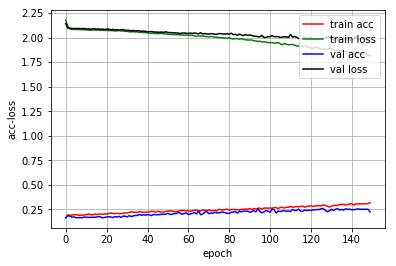

618/618 [==============================] - 0s 155us/step
test loss:  2.073003372328181
test accuracy:  0.25080906153689697


In [16]:
history.loss_plot('epoch')
loss_4, accuracy_4 = model.evaluate(test_x, test_y)
print('test loss: ', loss_4)
print('test accuracy: ', accuracy_4)

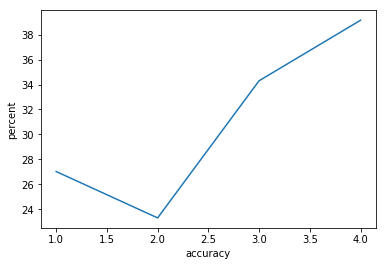

In [70]:
accuracy=[accuracy_1*100,accuracy_2*100,accuracy_3*100,accuracy_4*100]
number=[1,2,3,4]
plt.plot(number, accuracy)
plt.xlabel("accuracy")
plt.ylabel("percent")
plt.show()